Author(s): Piyush Amitabh

Details: this code downsamples, segments neutrophils, saves regionprops to csv

Created: March 31, 2022

License: GNU GPL v3.0

Edited: May 22, 2022

Description: 
1. deleted lots of trials and napari's usage (refer v4 for more details on these)
2. read the downsampled image directly
2. calculate and save updated csv files which includes surface area and sphericity info

Edited: June 23, 2022

Comments: 
1. extended to all the timepoints and positions
2. removed all usage of napari

Edited: July 06, 2022

Comments: 
1. changed for new timelapse data with 3min consistent time intervals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# import napari
# from napari import layers
# from napari.utils.notebook_display import nbscreenshot #for screenshots of napari viewer

import skimage
from PIL import Image, TiffTags
import tifffile as tiff
import os

In [2]:
# from skimage.segmentation import watershed
# from skimage.feature import peak_local_max
# from skimage import exposure, io, util

In [3]:
from tqdm import tqdm
import dask
from natsort import natsorted
from mayavi import mlab

# helper functions and constants

In [4]:
#function to enhance and show images
def show_image(img, img_title='', color=False, max_contrast=False):
    fig = plt.figure(figsize=(20,15))
    img = np.array(img)
    if max_contrast==True:
        enhance = skimage.exposure.equalize_hist(img)
    else:
        enhance = img
    if color==False:
        plt.imshow(enhance, cmap='gray')
    else:
        plt.imshow(enhance)
    plt.title(img_title)
    plt.colorbar()
    plt.axis("off")
    plt.show()

In [5]:
#find the stats of array (can take time)
def find_stats(ar):
    mean_xtrain = np.mean(ar)
    std_xtrain = np.std(ar)
    max_xtrain = np.max(ar)
    min_xtrain = np.min(ar)
    print(f'Stats: mean={mean_xtrain:.3f}, std={std_xtrain:.3f}, min={min_xtrain}, max={max_xtrain}')

The pixel spacing in this dataset is 1µm in the z (leading!) axis, and  0.1625µm in the x and y axes.

In [6]:
n = 4 #downscaling factor in x and y
zd, xd, yd = 1, 0.1625, 0.1625 #zeroth dimension is z
orig_spacing = np.array([zd, xd, yd]) #change to the actual pixel spacing from the microscope
new_spacing = np.array([zd, xd*n, yd*n]) #downscale x&y by n

change below directory structure to point to zstack images

In [25]:
main_dir = ['/home/piyush/Downloads/DATA/time lapse_063022/']

In [26]:
sub_dir = ['GFP', 'RFP']
dir_path = main_dir[0] + sub_dir[0] + '/'
dir_path

'/home/piyush/Downloads/DATA/time lapse_063022/GFP/'

In [27]:
listfiles = []
for img_files in natsorted(os.listdir(dir_path)): 
    if img_files.endswith(".tif"):
        listfiles.append(img_files)

In [28]:
listfiles

['Timepoint1_Pos1_GFP_ds.tif',
 'Timepoint1_Pos2_GFP_ds.tif',
 'Timepoint1_Pos3_GFP_ds.tif',
 'Timepoint1_Pos4_GFP_ds.tif',
 'Timepoint2_Pos1_GFP_ds.tif',
 'Timepoint2_Pos2_GFP_ds.tif',
 'Timepoint2_Pos3_GFP_ds.tif',
 'Timepoint2_Pos4_GFP_ds.tif',
 'Timepoint3_Pos1_GFP_ds.tif',
 'Timepoint3_Pos2_GFP_ds.tif',
 'Timepoint3_Pos3_GFP_ds.tif',
 'Timepoint3_Pos4_GFP_ds.tif',
 'Timepoint4_Pos1_GFP_ds.tif',
 'Timepoint4_Pos2_GFP_ds.tif',
 'Timepoint4_Pos3_GFP_ds.tif',
 'Timepoint4_Pos4_GFP_ds.tif',
 'Timepoint5_Pos1_GFP_ds.tif',
 'Timepoint5_Pos2_GFP_ds.tif',
 'Timepoint5_Pos3_GFP_ds.tif',
 'Timepoint5_Pos4_GFP_ds.tif',
 'Timepoint6_Pos1_GFP_ds.tif',
 'Timepoint6_Pos2_GFP_ds.tif',
 'Timepoint6_Pos3_GFP_ds.tif',
 'Timepoint6_Pos4_GFP_ds.tif',
 'Timepoint7_Pos1_GFP_ds.tif',
 'Timepoint7_Pos2_GFP_ds.tif',
 'Timepoint7_Pos3_GFP_ds.tif',
 'Timepoint7_Pos4_GFP_ds.tif',
 'Timepoint8_Pos1_GFP_ds.tif',
 'Timepoint8_Pos2_GFP_ds.tif',
 'Timepoint8_Pos3_GFP_ds.tif',
 'Timepoint8_Pos4_GFP_ds.tif',
 'Timepo

listfiles now has all the downsampled images for gfp channel

# Read Full Image

read a sample image

In [11]:
img_val = listfiles[0]
stack_full = tiff.imread(dir_path+img_val)

# Thresholding

In [12]:
denoised = ndi.median_filter(stack_full, size=3)

## a. Manual Thresholding 

Use same thresholding value as found in v4 by visual inspection

In [13]:
# li_thresholded = denoised > filters.threshold_li(denoised) #poor results
simple_thresh = denoised>1200 #manual value

# Object Properties

In [15]:
labels = skimage.measure.label(simple_thresh)

## Check regionprops supported 3D properties

Not all properties are supported for 3D data. List all the supported and unsupported 3D measurements in skimage

In [14]:
regionprops = skimage.measure.regionprops(labels, intensity_image=stack_full )

supported = [] 
unsupported = []

for i, prop in tqdm(enumerate(regionprops[0])):
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)
    

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

40it [00:02, 16.51it/s]

Supported properties:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_normalized
  slice
  solidity

Unsupported properties:
  eccentricity
  moments_hu
  moments_weighted_hu
  orientation
  perimeter
  perimeter_crofton


## Generate 3D properties for Sample Image

In [16]:
info_table = pd.DataFrame(
    skimage.measure.regionprops_table(
        labels, 
        intensity_image=stack_full, 
        properties=['label', 'centroid', 'weighted_centroid',  'area', 'equivalent_diameter_area', 'mean_intensity', 'image', 'image_filled']
    )
).set_index('label')
info_table.head()

,centroid-0,centroid-1,centroid-2,weighted_centroid-0,weighted_centroid-1,weighted_centroid-2,area,equivalent_diameter_area,mean_intensity,image,image_filled
label,,,,,,,,,,,
1,13.748936,357.625205,14.787643,12.455736,357.679239,14.884741,12220,28.577497,4951.424642,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
2,12.332012,504.630137,4.648161,11.359813,505.052103,3.477234,8322,25.142572,3108.544370,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
3,13.543210,404.310887,1.927609,13.153373,404.712553,1.613449,1782,15.041911,2198.832632,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
4,28.320544,189.689792,236.073057,28.631440,189.695945,235.690020,7063,23.804745,8519.322791,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
5,46.637431,437.469993,368.996305,44.122565,436.811208,369.004012,32209,39.475370,3351.591337,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."


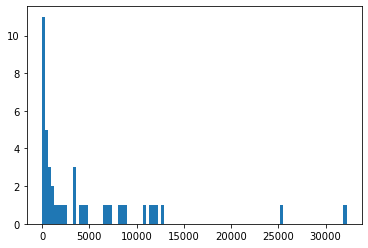

In [17]:
plt.hist(info_table.area, bins=100)
plt.show()

# Remove small objects

remove objects which are smaller than (10pixels) cubed = 1000 voxel volume = 26.5 um^3 (20+40*0.1625)

In [18]:
# voxel_width = 3/(0.1625**2) #corresponding to 3um^3
voxel_width = 10 ** 3 #1000 -> 26.5 um^3

just filtering the info dataframe and saving it

In [19]:
info_table_filt = info_table[info_table.area>voxel_width].copy()
# info_table_filt.to_csv('./img1_info.csv')

In [20]:
info_table_filt.head()

,centroid-0,centroid-1,centroid-2,weighted_centroid-0,weighted_centroid-1,weighted_centroid-2,area,equivalent_diameter_area,mean_intensity,image,image_filled
label,,,,,,,,,,,
1,13.748936,357.625205,14.787643,12.455736,357.679239,14.884741,12220,28.577497,4951.424642,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
2,12.332012,504.630137,4.648161,11.359813,505.052103,3.477234,8322,25.142572,3108.544370,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
3,13.543210,404.310887,1.927609,13.153373,404.712553,1.613449,1782,15.041911,2198.832632,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
4,28.320544,189.689792,236.073057,28.631440,189.695945,235.690020,7063,23.804745,8519.322791,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."
5,46.637431,437.469993,368.996305,44.122565,436.811208,369.004012,32209,39.475370,3351.591337,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F..."


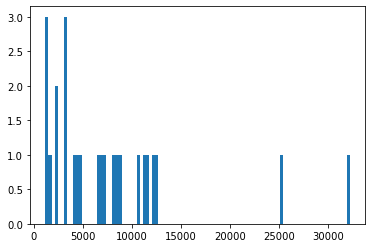

In [21]:
plt.hist(info_table_filt.area, bins=100)
plt.show()

# Add Surface Area

In [20]:
lst = []
for img_data in info_table_filt['image']:
    verts, faces, _, _ = skimage.measure.marching_cubes(img_data, spacing=new_spacing)
    lst.append(skimage.measure.mesh_surface_area(verts, faces))

In [21]:
info_table_filt['user_surface_area'] = lst

In [22]:
info_table_filt.head()

,centroid-0,centroid-1,centroid-2,weighted_centroid-0,weighted_centroid-1,weighted_centroid-2,area,equivalent_diameter_area,mean_intensity,image,image_filled,user_surface_area
label,,,,,,,,,,,,
1,38.768191,434.729954,40.848073,38.650335,434.328504,40.424709,26414,36.949779,1779.329747,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F...",5253.578292
2,28.462274,213.010010,271.638876,27.899091,212.943223,270.815313,6693,23.381591,6967.569093,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F...",1246.701571
3,35.683329,230.142198,130.476583,35.508769,230.342089,129.895215,4121,19.891521,5660.826483,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F...",825.631721
5,40.377745,266.646818,315.038705,40.350437,266.687699,315.300263,2687,17.248699,2967.428940,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F...",798.462165
6,38.273973,234.637649,291.076005,38.219334,234.769968,290.539367,2263,16.289033,3721.094758,"[[[False, False, False, False, False, False, F...","[[[False, False, False, False, False, False, F...",559.307298


In [133]:
info_table_filt['sphericity'] = np.pi*np.square(info_table_filt['equivalent_diameter_area'])/info_table_filt['user_surface_area']

In [134]:
info_table_filt.head()

,centroid-0,centroid-1,centroid-2,weighted_centroid-0,weighted_centroid-1,weighted_centroid-2,area,equivalent_diameter_area,mean_intensity,image,user_surface_area,sphericity
label,,,,,,,,,,,,
1,38.768191,434.729954,40.848073,38.650335,434.328504,40.424709,26414,36.949779,1779.329747,"[[[False, False, False, False, False, False, F...",5253.578292,0.816429
2,28.462274,213.010010,271.638876,27.899091,212.943223,270.815313,6693,23.381591,6967.569093,"[[[False, False, False, False, False, False, F...",1246.701571,1.377639
3,35.683329,230.142198,130.476583,35.508769,230.342089,129.895215,4121,19.891521,5660.826483,"[[[False, False, False, False, False, False, F...",825.631721,1.505565
5,40.377745,266.646818,315.038705,40.350437,266.687699,315.300263,2687,17.248699,2967.428940,"[[[False, False, False, False, False, False, F...",798.462165,1.170599
6,38.273973,234.637649,291.076005,38.219334,234.769968,290.539367,2263,16.289033,3721.094758,"[[[False, False, False, False, False, False, F...",559.307298,1.490356


In [137]:
info_table_filt.iloc[2]

centroid-0                                                          35.683329
centroid-1                                                         230.142198
centroid-2                                                         130.476583
weighted_centroid-0                                                 35.508769
weighted_centroid-1                                                230.342089
weighted_centroid-2                                                129.895215
area                                                                     4121
equivalent_diameter_area                                            19.891521
mean_intensity                                                    5660.826483
image                       [[[False, False, False, False, False, False, F...
user_surface_area                                                  825.631721
sphericity                                                           1.505565
Name: 3, dtype: object

last update: this surface area calculation is not correct as it is leaving holes open, giving Sphericity values >1. Not saving this in our tables now.

# Loop over all images and save info


takes ~1 hr for all timepoints

In [22]:
# def segment_save_props(img_path, csv_name):
#     """
#     Description:
#     Reads full size images given by 'img_path', downsamples them, finds properties and saves them in 'csv_name'
#     """
#     dir = img_path

#     listfiles =[]
#     for img_files in sorted(os.listdir(dir)):
#         if img_files.endswith(".tif"):
#             listfiles.append(img_files)

#     first_image = tiff.imread(dir+listfiles[0])
#     first_image = tiff.imread(dir+listfiles[0])
#     stack_full = np.zeros((len(listfiles),first_image.shape[0]//n,first_image.shape[1]//n))#,np.uint16)

#     for i, val in enumerate(listfiles):
#         # print(i,val)
#         img = tiff.imread(dir+val)
#         img_downscaled = skimage.transform.downscale_local_mean(img, (n, n)) #use a kernel of nxn, this will downscale by a factor of n in both x & y
#         stack_full[i,:,:] = img_downscaled

#     denoised = ndi.median_filter(stack_full, size=3)
#     simple_thresh = denoised>1200 #manual value
#     labels = skimage.measure.label(simple_thresh)
#     info_table = pd.DataFrame(
#         skimage.measure.regionprops_table(
#             labels, 
#             intensity_image=stack_full, 
#             properties=['label', 'centroid', 'weighted_centroid',  'area', 'equivalent_diameter', 'mean_intensity', 'coords']#, #'slice',
#         )
#     ).set_index('label')
#     # voxel_width = 3/(0.1625**2) #corresponding to 3um^3
#     voxel_width = 10 ** 3 #1000 -> 26.5 um^3
#     info_table_filt = info_table[info_table.area>voxel_width] #filter objects by size
#     info_table_filt.to_csv('./'+csv_name)
#     print('Successfully saved: '+csv_name)

In [23]:
def segment_save_props_ds(img_path, save_path, csv_name):
    """
    Description:
    Reads downsampled images given by 'img_path', finds properties and saves them in 'csv_name' at 'save_path'
    """
    stack_full = tiff.imread(img_path)
    denoised = ndi.median_filter(stack_full, size=3)
    simple_thresh = denoised>1200 #manual value
    labels = skimage.measure.label(simple_thresh)
    info_table = pd.DataFrame(
        skimage.measure.regionprops_table(
            labels, 
            intensity_image=stack_full, 
            properties=['label', 'centroid', 'weighted_centroid',  'area', 'equivalent_diameter', 'mean_intensity', 'coords']#, #'slice',
        )
    ).set_index('label')
    # voxel_width = 3/(0.1625**2) #corresponding to 3um^3
    voxel_width = 10 ** 3 #1000 -> 26.5 um^3
    info_table_filt = info_table[info_table.area>voxel_width] #filter objects by size
    info_table_filt.to_csv(save_path+csv_name)
    print('Successfully saved: '+csv_name)

## Save region props for all the time points

In [29]:
listfiles

['Timepoint1_Pos1_GFP_ds.tif',
 'Timepoint1_Pos2_GFP_ds.tif',
 'Timepoint1_Pos3_GFP_ds.tif',
 'Timepoint1_Pos4_GFP_ds.tif',
 'Timepoint2_Pos1_GFP_ds.tif',
 'Timepoint2_Pos2_GFP_ds.tif',
 'Timepoint2_Pos3_GFP_ds.tif',
 'Timepoint2_Pos4_GFP_ds.tif',
 'Timepoint3_Pos1_GFP_ds.tif',
 'Timepoint3_Pos2_GFP_ds.tif',
 'Timepoint3_Pos3_GFP_ds.tif',
 'Timepoint3_Pos4_GFP_ds.tif',
 'Timepoint4_Pos1_GFP_ds.tif',
 'Timepoint4_Pos2_GFP_ds.tif',
 'Timepoint4_Pos3_GFP_ds.tif',
 'Timepoint4_Pos4_GFP_ds.tif',
 'Timepoint5_Pos1_GFP_ds.tif',
 'Timepoint5_Pos2_GFP_ds.tif',
 'Timepoint5_Pos3_GFP_ds.tif',
 'Timepoint5_Pos4_GFP_ds.tif',
 'Timepoint6_Pos1_GFP_ds.tif',
 'Timepoint6_Pos2_GFP_ds.tif',
 'Timepoint6_Pos3_GFP_ds.tif',
 'Timepoint6_Pos4_GFP_ds.tif',
 'Timepoint7_Pos1_GFP_ds.tif',
 'Timepoint7_Pos2_GFP_ds.tif',
 'Timepoint7_Pos3_GFP_ds.tif',
 'Timepoint7_Pos4_GFP_ds.tif',
 'Timepoint8_Pos1_GFP_ds.tif',
 'Timepoint8_Pos2_GFP_ds.tif',
 'Timepoint8_Pos3_GFP_ds.tif',
 'Timepoint8_Pos4_GFP_ds.tif',
 'Timepo

listfiles now has all the downsampled images for gfp channel

In [30]:
main_dir = ['/home/piyush/Downloads/DATA/time lapse_063022/']
sub_dir = ['GFP', 'RFP']
dir_path = main_dir[0] + sub_dir[0] + '/' #path for images
dir_path

'/home/piyush/Downloads/DATA/time lapse_063022/GFP/'

In [31]:
save_path = '/home/piyush/Dropbox/Research/Exp Data/analysis_time lapse_063022/' #path to save tables

In [32]:
for img_name in tqdm(listfiles):
    img_path = dir_path+img_name
    print('Reading: '+img_path)
    segment_save_props_ds(img_path=img_path, save_path=save_path, csv_name=img_name[:-4]+'_info.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint1_Pos1_GFP_ds.tif


  2%|▏         | 1/60 [00:48<47:13, 48.02s/it]

Successfully saved: Timepoint1_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint1_Pos2_GFP_ds.tif


  3%|▎         | 2/60 [01:23<39:11, 40.54s/it]

Successfully saved: Timepoint1_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint1_Pos3_GFP_ds.tif


  5%|▌         | 3/60 [01:43<29:35, 31.14s/it]

Successfully saved: Timepoint1_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint1_Pos4_GFP_ds.tif


  7%|▋         | 4/60 [02:04<25:14, 27.05s/it]

Successfully saved: Timepoint1_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint2_Pos1_GFP_ds.tif


  8%|▊         | 5/60 [02:52<31:51, 34.76s/it]

Successfully saved: Timepoint2_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint2_Pos2_GFP_ds.tif


 10%|█         | 6/60 [03:27<31:16, 34.74s/it]

Successfully saved: Timepoint2_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint2_Pos3_GFP_ds.tif


 12%|█▏        | 7/60 [03:46<26:12, 29.66s/it]

Successfully saved: Timepoint2_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint2_Pos4_GFP_ds.tif


 13%|█▎        | 8/60 [04:07<23:14, 26.81s/it]

Successfully saved: Timepoint2_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint3_Pos1_GFP_ds.tif


 15%|█▌        | 9/60 [04:54<28:18, 33.31s/it]

Successfully saved: Timepoint3_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint3_Pos2_GFP_ds.tif


 17%|█▋        | 10/60 [05:28<27:56, 33.53s/it]

Successfully saved: Timepoint3_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint3_Pos3_GFP_ds.tif


 18%|█▊        | 11/60 [05:47<23:47, 29.13s/it]

Successfully saved: Timepoint3_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint3_Pos4_GFP_ds.tif


 20%|██        | 12/60 [06:07<21:06, 26.39s/it]

Successfully saved: Timepoint3_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint4_Pos1_GFP_ds.tif


 22%|██▏       | 13/60 [06:59<26:42, 34.10s/it]

Successfully saved: Timepoint4_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint4_Pos2_GFP_ds.tif


 23%|██▎       | 14/60 [07:35<26:30, 34.58s/it]

Successfully saved: Timepoint4_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint4_Pos3_GFP_ds.tif


 25%|██▌       | 15/60 [07:57<22:58, 30.64s/it]

Successfully saved: Timepoint4_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint4_Pos4_GFP_ds.tif


 27%|██▋       | 16/60 [08:17<20:15, 27.63s/it]

Successfully saved: Timepoint4_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint5_Pos1_GFP_ds.tif


 28%|██▊       | 17/60 [09:05<24:13, 33.80s/it]

Successfully saved: Timepoint5_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint5_Pos2_GFP_ds.tif


 30%|███       | 18/60 [09:39<23:39, 33.79s/it]

Successfully saved: Timepoint5_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint5_Pos3_GFP_ds.tif


 32%|███▏      | 19/60 [09:59<20:10, 29.51s/it]

Successfully saved: Timepoint5_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint5_Pos4_GFP_ds.tif


 33%|███▎      | 20/60 [10:19<17:50, 26.75s/it]

Successfully saved: Timepoint5_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint6_Pos1_GFP_ds.tif


 35%|███▌      | 21/60 [11:08<21:45, 33.47s/it]

Successfully saved: Timepoint6_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint6_Pos2_GFP_ds.tif


 37%|███▋      | 22/60 [11:42<21:21, 33.73s/it]

Successfully saved: Timepoint6_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint6_Pos3_GFP_ds.tif


 38%|███▊      | 23/60 [12:02<18:11, 29.49s/it]

Successfully saved: Timepoint6_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint6_Pos4_GFP_ds.tif


 40%|████      | 24/60 [12:22<16:02, 26.75s/it]

Successfully saved: Timepoint6_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint7_Pos1_GFP_ds.tif


 42%|████▏     | 25/60 [13:11<19:26, 33.32s/it]

Successfully saved: Timepoint7_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint7_Pos2_GFP_ds.tif


 43%|████▎     | 26/60 [13:46<19:10, 33.83s/it]

Successfully saved: Timepoint7_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint7_Pos3_GFP_ds.tif


 45%|████▌     | 27/60 [14:05<16:13, 29.50s/it]

Successfully saved: Timepoint7_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint7_Pos4_GFP_ds.tif


 47%|████▋     | 28/60 [14:26<14:14, 26.70s/it]

Successfully saved: Timepoint7_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint8_Pos1_GFP_ds.tif


 48%|████▊     | 29/60 [15:14<17:07, 33.16s/it]

Successfully saved: Timepoint8_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint8_Pos2_GFP_ds.tif


 50%|█████     | 30/60 [15:48<16:42, 33.41s/it]

Successfully saved: Timepoint8_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint8_Pos3_GFP_ds.tif


 52%|█████▏    | 31/60 [16:07<14:06, 29.19s/it]

Successfully saved: Timepoint8_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint8_Pos4_GFP_ds.tif


 53%|█████▎    | 32/60 [16:27<12:20, 26.45s/it]

Successfully saved: Timepoint8_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint9_Pos1_GFP_ds.tif


 55%|█████▌    | 33/60 [17:15<14:47, 32.86s/it]

Successfully saved: Timepoint9_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint9_Pos2_GFP_ds.tif


 57%|█████▋    | 34/60 [17:49<14:24, 33.23s/it]

Successfully saved: Timepoint9_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint9_Pos3_GFP_ds.tif


 58%|█████▊    | 35/60 [18:09<12:07, 29.09s/it]

Successfully saved: Timepoint9_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint9_Pos4_GFP_ds.tif


 60%|██████    | 36/60 [18:29<10:33, 26.39s/it]

Successfully saved: Timepoint9_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint10_Pos1_GFP_ds.tif


 62%|██████▏   | 37/60 [19:18<12:42, 33.14s/it]

Successfully saved: Timepoint10_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint10_Pos2_GFP_ds.tif


 63%|██████▎   | 38/60 [19:51<12:14, 33.38s/it]

Successfully saved: Timepoint10_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint10_Pos3_GFP_ds.tif


 65%|██████▌   | 39/60 [20:11<10:12, 29.15s/it]

Successfully saved: Timepoint10_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint10_Pos4_GFP_ds.tif


 67%|██████▋   | 40/60 [20:31<08:49, 26.45s/it]

Successfully saved: Timepoint10_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint11_Pos1_GFP_ds.tif


 68%|██████▊   | 41/60 [21:19<10:26, 32.96s/it]

Successfully saved: Timepoint11_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint11_Pos2_GFP_ds.tif


 70%|███████   | 42/60 [21:53<09:57, 33.20s/it]

Successfully saved: Timepoint11_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint11_Pos3_GFP_ds.tif


 72%|███████▏  | 43/60 [22:12<08:13, 29.04s/it]

Successfully saved: Timepoint11_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint11_Pos4_GFP_ds.tif


 73%|███████▎  | 44/60 [22:32<07:00, 26.25s/it]

Successfully saved: Timepoint11_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint12_Pos1_GFP_ds.tif


 75%|███████▌  | 45/60 [23:20<08:12, 32.83s/it]

Successfully saved: Timepoint12_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint12_Pos2_GFP_ds.tif


 77%|███████▋  | 46/60 [23:53<07:41, 32.96s/it]

Successfully saved: Timepoint12_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint12_Pos3_GFP_ds.tif


 78%|███████▊  | 47/60 [24:12<06:10, 28.53s/it]

Successfully saved: Timepoint12_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint12_Pos4_GFP_ds.tif


 80%|████████  | 48/60 [24:30<05:07, 25.62s/it]

Successfully saved: Timepoint12_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint13_Pos1_GFP_ds.tif


 82%|████████▏ | 49/60 [25:16<05:48, 31.64s/it]

Successfully saved: Timepoint13_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint13_Pos2_GFP_ds.tif


 83%|████████▎ | 50/60 [25:48<05:18, 31.83s/it]

Successfully saved: Timepoint13_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint13_Pos3_GFP_ds.tif


 85%|████████▌ | 51/60 [26:06<04:09, 27.73s/it]

Successfully saved: Timepoint13_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint13_Pos4_GFP_ds.tif


 87%|████████▋ | 52/60 [26:26<03:21, 25.16s/it]

Successfully saved: Timepoint13_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint14_Pos1_GFP_ds.tif


 88%|████████▊ | 53/60 [27:11<03:39, 31.34s/it]

Successfully saved: Timepoint14_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint14_Pos2_GFP_ds.tif


 90%|█████████ | 54/60 [27:44<03:09, 31.62s/it]

Successfully saved: Timepoint14_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint14_Pos3_GFP_ds.tif


 92%|█████████▏| 55/60 [28:02<02:18, 27.61s/it]

Successfully saved: Timepoint14_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint14_Pos4_GFP_ds.tif


 93%|█████████▎| 56/60 [28:21<01:40, 25.06s/it]

Successfully saved: Timepoint14_Pos4_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint15_Pos1_GFP_ds.tif


 95%|█████████▌| 57/60 [29:06<01:33, 31.09s/it]

Successfully saved: Timepoint15_Pos1_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint15_Pos2_GFP_ds.tif


 97%|█████████▋| 58/60 [29:38<01:02, 31.40s/it]

Successfully saved: Timepoint15_Pos2_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint15_Pos3_GFP_ds.tif


 98%|█████████▊| 59/60 [29:57<00:27, 27.44s/it]

Successfully saved: Timepoint15_Pos3_GFP_ds_info.csv
Reading: /home/piyush/Downloads/DATA/time lapse_063022/GFP/Timepoint15_Pos4_GFP_ds.tif


100%|██████████| 60/60 [30:16<00:00, 30.27s/it]

Successfully saved: Timepoint15_Pos4_GFP_ds_info.csv


# Analysis and Linking

see: analysis_n_linking.ipynb

---